In [67]:
%matplotlib inline
import numpy as np
import skimage.external.tifffile
import os
import matplotlib.pyplot as plt
from PIL import Image

import multiprocessing  
from multiprocessing import Pool

import pylattice as pyl
import pylattice.functions.TiffProcessing as tifproc

import sys
sys.path.append('/Users/johannesschoeneberg/git/JohSchoeneberg/pyLattice/src/python/pylattice/functions')
import ParallelFunctions

In [190]:
truthFile = "/Users/johannesschoeneberg/git/JohSchoeneberg/pyLatticeML/src/evaluationMetrics/evaluationMetricTest.tif"
predictionFile = "/Users/johannesschoeneberg/git/JohSchoeneberg/pyLatticeML/src/evaluationMetrics/evaluationMetricTest_prediction.tif"


In [191]:
truth = ParallelFunctions.open3dTiff(truthFile)
prediction = ParallelFunctions.open3dTiff(predictionFile)

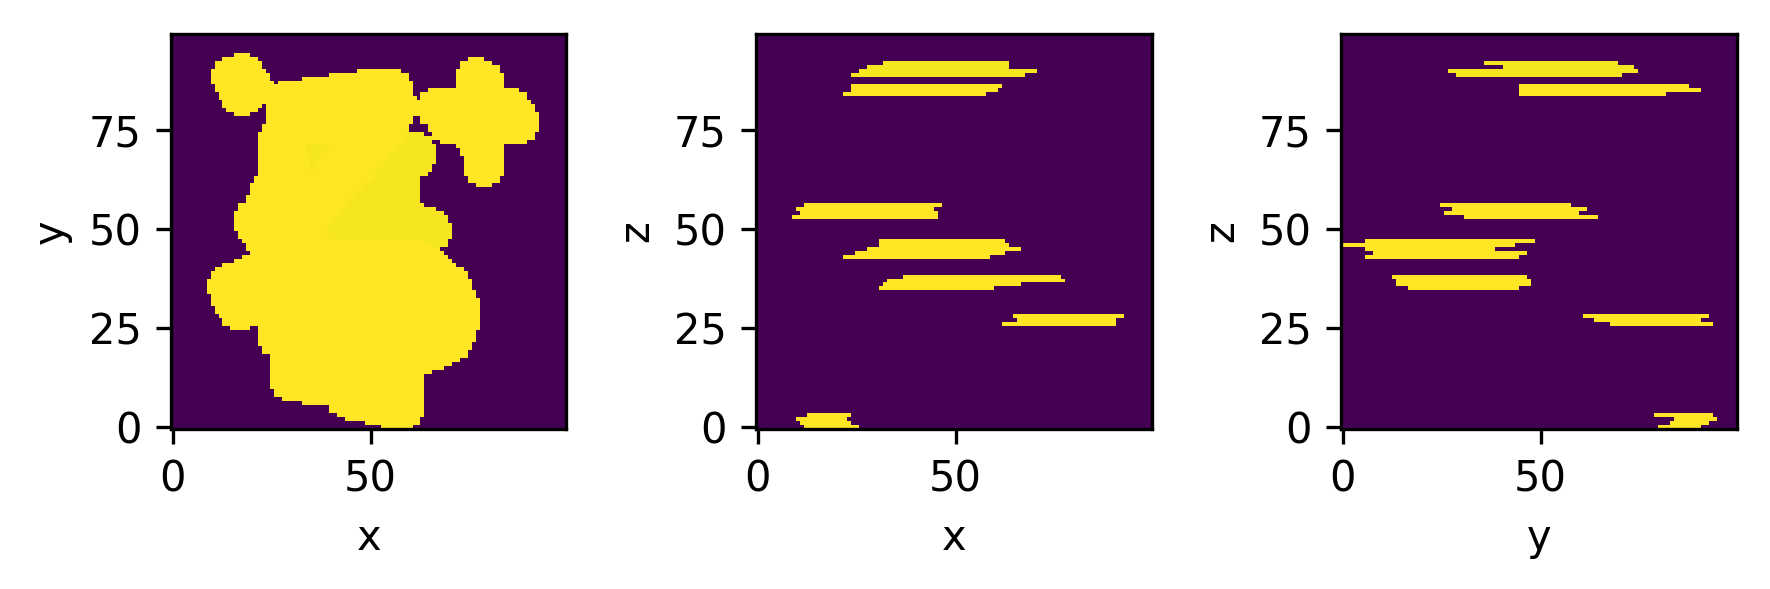

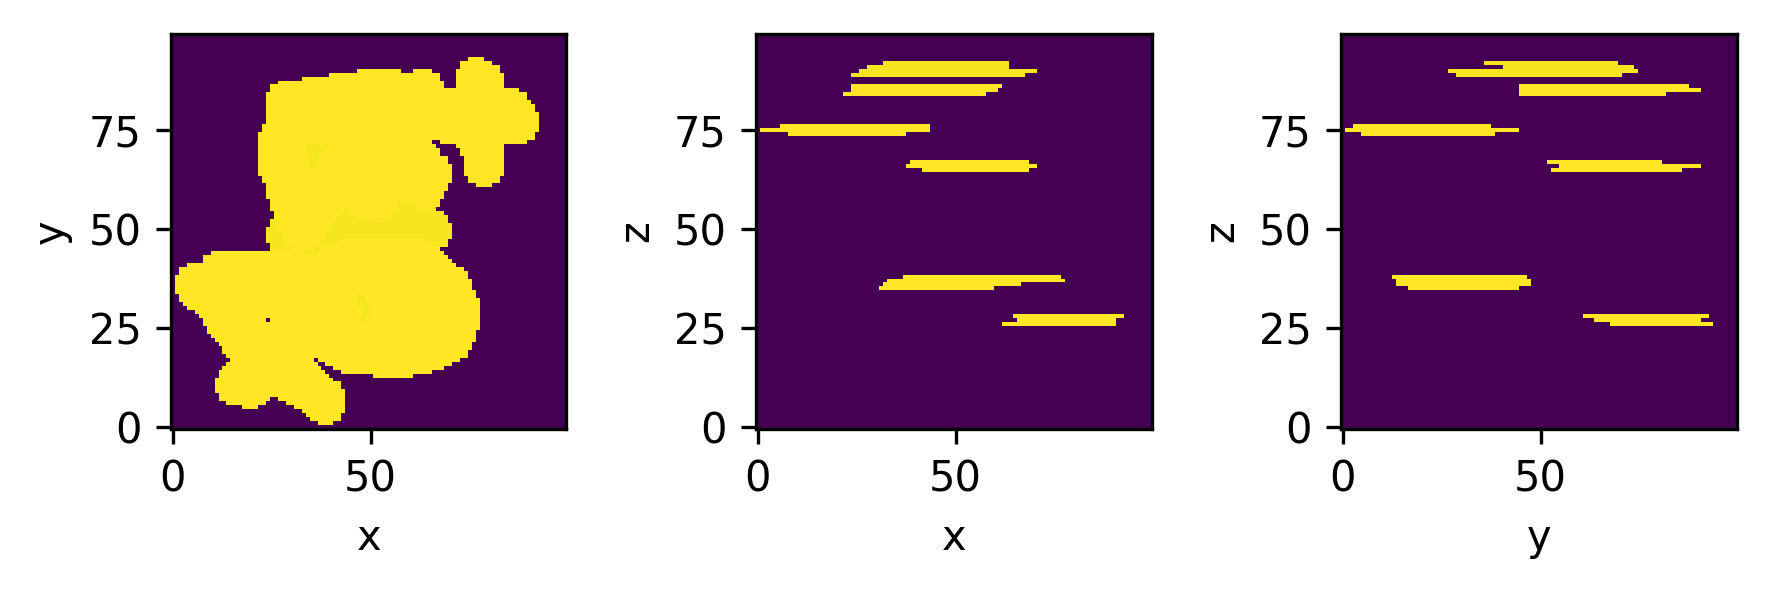

In [192]:
tifproc.maxIntensityProjection(truth)
tifproc.maxIntensityProjection(prediction)

# label all connected components in the mask

In [193]:
from scipy import ndimage
label_im, nb_labels = ndimage.label(truth)
print(nb_labels)

7


In [194]:
import skimage
import os

multiplierForOutput = 1
outputPath_tiff = "./truth_components_labeled.tiff"
skimage.external.tifffile.imsave(outputPath_tiff, (label_im*multiplierForOutput).astype('uint16'))    
print(os.path.abspath(outputPath_tiff))


/Users/johannesschoeneberg/git/JohSchoeneberg/pyLatticeML/src/evaluationMetrics/truth_components_labeled.tiff


In [195]:
print(nb_labels)

7


In [196]:
ndimage.find_objects(label_im==4)[0]

(slice(43, 48, None), slice(0, 49, None), slice(22, 67, None))

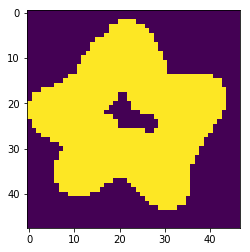

In [197]:
slice_z, slice_x, slice_y  = ndimage.find_objects(label_im==7)[0]
roi = truth[slice_z, slice_x, slice_y]
plt.imshow(roi[0])     

In [198]:
ndimage.measurements.center_of_mass(truth)

(57.24071409562231, 44.89930943314572, 44.789502090478805)

In [199]:
label_im, nb_labels = ndimage.label(truth)
truth_allCentersOfMass = ndimage.measurements.center_of_mass(truth, label_im,range(1,nb_labels+1) )
pprint(truth_allCentersOfMass)

[(1.525879917184265, 86.85300207039337, 17.354037267080745),
 (27.045346062052506, 78.1376292760541, 77.70723945902944),
 (36.651155809066346, 30.07985589912939, 51.759231462023415),
 (44.980590215884334, 24.50188156070509, 44.50306991483462),
 (54.48005319148936, 41.00975177304964, 27.066932624113477),
 (85.05804843304843, 69.69658119658119, 38.444088319088316),
 (90.28431631843428, 52.78101031473155, 46.90478709336154)]


In [200]:
label_im, nb_labels = ndimage.label(prediction)
prediction_allCentersOfMass = ndimage.measurements.center_of_mass(prediction, label_im,range(1,nb_labels+1) )
pprint(prediction_allCentersOfMass)

[(27.045346062052506, 78.1376292760541, 77.70723945902944),
 (36.651155809066346, 30.07985589912939, 51.759231462023415),
 (65.99887514060742, 70.09786276715411, 54.82902137232846),
 (75.0457083042568, 23.760642009769715, 24.348918353105372),
 (85.05804843304843, 69.69658119658119, 38.444088319088316),
 (90.28431631843428, 52.78101031473155, 46.90478709336154)]


In [201]:
# find the closest match between points
# if that distance is below threshold: match -> remove both locations, put predicted location into TP
# if that distance is above threshold: no-match found -> put the predicted location into FP
# end 1: put remaining locations in truth into FN (false negative, i.e. there is something but we predicted nothing)
# end 2: put the remaining locations in prediction into FP 

In [202]:
prediction_truth_matches = []
distanceThreshold = 1

truth_allCentersOfMass_available_for_match = truth_allCentersOfMass
for predictionCOM in prediction_allCentersOfMass:
    # got throuth the array and find the closest center of mass (COM) to that prediction
    closestDistance = 10000
    closestTruthCOM = []
    for truthCOM in truth_allCentersOfMass_available_for_match:
        if(False):
            print("pred {}".format(predictionCOM))
            print(truthCOM)
            print("dist {}".format(dist))
        dist = np.linalg.norm(np.array(predictionCOM)-np.array(truthCOM))
        if(dist < closestDistance):
            closestDistance = dist
            closestTruthCOM = truthCOM
    # in the end, check if that closest found COM is a shorter distance away than your threshold
    if(closestDistance < distanceThreshold):
        if(False):
            print([predictionCOM,closestTruthCOM,closestDistance])
        prediction_truth_matches.append([predictionCOM,closestTruthCOM,closestDistance])
        # remove the location to prevent double counting
        itemindex = np.where(truth_allCentersOfMass_available_for_match==closestTruthCOM)
        np.delete(truth_allCentersOfMass_available_for_match, itemindex)
    #else:
        #prediction_truth_matches.append([predictionCOM,None,None])


In [203]:
from pprint import pprint
pprint(prediction_truth_matches)
print(len(prediction_truth_matches))

[[(27.045346062052506, 78.1376292760541, 77.70723945902944),
  (27.045346062052506, 78.1376292760541, 77.70723945902944),
  0.0],
 [(36.651155809066346, 30.07985589912939, 51.759231462023415),
  (36.651155809066346, 30.07985589912939, 51.759231462023415),
  0.0],
 [(85.05804843304843, 69.69658119658119, 38.444088319088316),
  (85.05804843304843, 69.69658119658119, 38.444088319088316),
  0.0],
 [(90.28431631843428, 52.78101031473155, 46.90478709336154),
  (90.28431631843428, 52.78101031473155, 46.90478709336154),
  0.0]]
4


In [204]:
print(len(truth_allCentersOfMass))
print(len(prediction_allCentersOfMass))

7
6


In [205]:
M_precision = len(prediction_truth_matches)/float(len(truth_allCentersOfMass))
M_recall = len(prediction_truth_matches)/len(prediction_allCentersOfMass)
F1_score = 2*M_precision*M_recall/(M_precision+M_recall)
print("M_precision {}".format(M_precision))
print("M_recall {}".format(M_recall))
print("F1_score {}".format(F1_score))

M_precision 0.5714285714285714
M_recall 0.6666666666666666
F1_score 0.6153846153846153
